<a href="https://colab.research.google.com/github/yelenana/machine_learning/blob/main/Rybchynska_Olena__%22HW_2_2_%D0%9F%D0%BE%D0%BB%D1%96%D0%BD%D0%BE%D0%BC%D1%96%D0%B0%D0%BB%D1%8C%D0%BD%D1%96_%D0%BE%D0%B7%D0%BD%D0%B0%D0%BA%D0%B8_Pipelines_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми проведемо додаткові експерименти для рішення задачі бінарної класифікації і створимо ваш новий submission на змагання на Kaggle.

-----------


**Завдання 0**. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle)  Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").


**Завдання 1**. **Збираємо весь код з попереднього ДЗ в одному місці.** В лекційному ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb` ми познайомились з поняттям пайплайнів, а також я показала, як компактно виглядає рішення МЛ задачі, якщо ми зберемо весь код разом.

Оскільки ми далі будемо робити експерименти, які включають ті самі етапи попередньої обробки, але інше моделювання - буде зручно мати весь код компактно і під рукою. Тому зараз ми займемось збором коду до купи :) Після цього завдання для подальших експериментів ви можете перенести частини розвʼязку взагалі в окремий `.py` файл, аби було зручно імпортувати функції.

Зі свого рішення в попередньому домашньому завданні (`Логістична регресія з scikit learn.ipynb`) зберіть усі кроки розвʼязку задачі разом з використанням `sklearn.Pipeline` за прикладом з лекції.

Ваш код нижче має містити
1. Читання даних з файлу (поза пайплайном).
2. Розбиття на тренувальний і валідаційний набори, де валідаційний містить 20% даних (поза пайплайном).
3. Виділення категоріальних і числових колонок (поза пайплайном).
4. Підготовку категоріальних і числових колонок (частина пайплайну). В прикладі в лекції ми оформлювали обробку числових і категоріальних колонок в окремі трансформери `numeric_transformer`, `categorical_cols`. Рекоемндую зробити саме так, так потім зручніше вносити зміни :)
5. Тренування лог регресії (частина пайплайну).
6. Запуск пайплайну на тренування на трен. даних (поза пайплайном).
7. Запуск пайплайну на передбачення на трен і вал. даних і вимір метрик якості ROC-AUC + вивдення Confusion Matrix (поза пайплайном).
8. Збереження моделі в формат joblib (поза пайплайном).

Ви це все вже зробили в попереднтьому ДЗ! Тож, тут просто заадча все зібрати разом.

Нижче я додала підказки, що покроково ви маєте зробити. Якщо ви почуваєтесь впевнено, можете видалити ці підказки і реалізувати все самостійно, або ж - просто заповнити пропуски.

Завдання оцінюється в 10 балів. Головний результат - аби код в фіналі був робочий. Бо за не робочий нам гроші ніхто не заплатить :)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: olenarybchynska
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling


100%|██████████| 262k/262k [00:00<00:00, 418MB/s]

Area under ROC score on Validation dataset: 0.65%


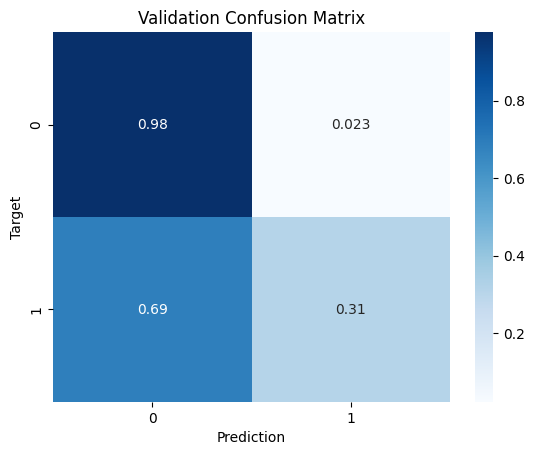

Area under ROC score on Test dataset: 0.57%


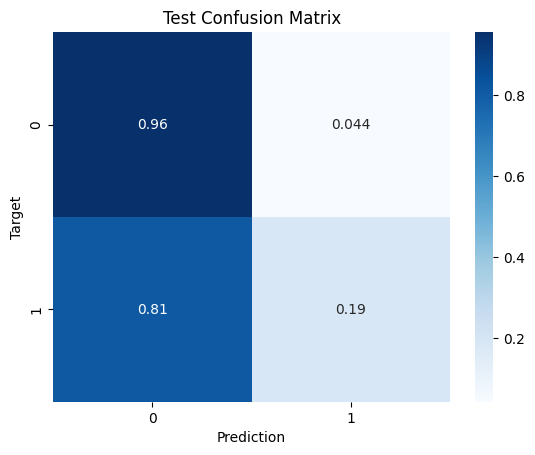

['bank-customer-churn-model.joblib']

In [1]:
!pip install opendatasets --upgrade --quiet

import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

od.download('https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling/sample_data')
raw_df = pd.read_csv('bank-customer-churn-modeling/Churn_Modelling.csv', index_col=0)
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

# Створюємо трен. і вал. набори
input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]


# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в один препроцесор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо пайплайн, який спочатку запускає препроцесинг, потім тренуєм модель
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])


# Тренуємо пайплайн
model_pipeline.fit(train_inputs,train_targets)

def predict_and_plot(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.2f}%")
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо модель на трен і вал даних
train_preds = predict_and_plot(model_pipeline, train_inputs, train_targets, 'Validation')
val_preds = predict_and_plot(model_pipeline,val_inputs, val_targets, 'Test')

# Зберігаємо модель для подальшого
# використання
joblib.dump(model_pipeline, 'bank-customer-churn-model.joblib')

**Завдання 2**. Такс, у нас з вами є вже готовий пайплайн. Давайте проведемо нові експерименти.

  Додайте в попередню обробку числових колонок генерацію polinomal features до степені 2 включно. Для цього створіть новий препроцесор і створіть новий пайплайн.

  Запустіть пайплайн на тренування і виведіть метрики для тренувального і валідаційного набору. Напишіть, як вам модель? Чи спостерігається в цій моделі overfit чи underfit? Чи ця модель добре генералізує?



---
Виконання завдання 2:
Для отримання кращих результатів по навчанню моделі, я додала опцію  class_weight='balanced' при тренування моделі


Training new pipeline with polynomial features...
Training complete.

--- Metrics for Model with Polynomial Features ---
Area under ROC score on Train dataset: 0.8326


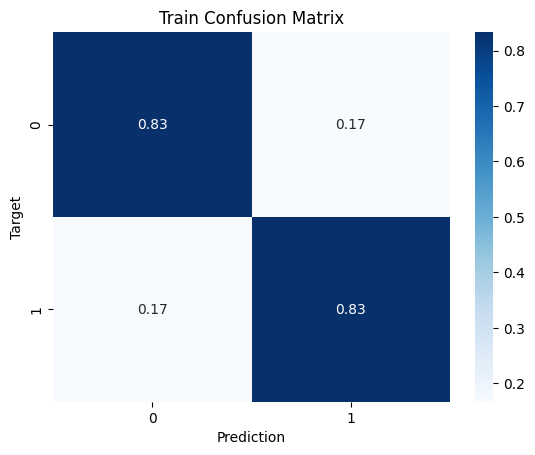

Area under ROC score on Validation dataset: 0.7229


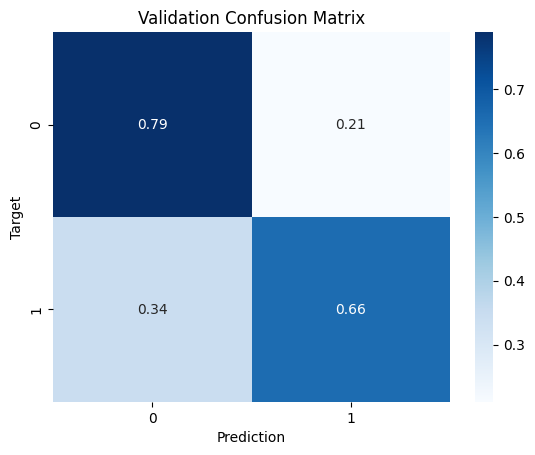


New model with polynomial features saved as 'bank-customer-churn-model-poly.joblib'


In [2]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Завантаження даних
raw_df = pd.read_csv('bank-customer-churn-modeling/Churn_Modelling.csv', index_col=0)
train_df, val_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
val_inputs, val_targets = val_df[input_cols], val_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок з PolynomialFeatures
numeric_transformer_poly = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), # Додаємо PolynomialFeatures
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в новий препроцесор
preprocessor_poly = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо новий пайплайн з оновленим препроцесором
model_pipeline_poly2 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

# Тренуємо новий пайплайн
print("Training new pipeline with polynomial features...")
model_pipeline_poly2.fit(train_inputs,train_targets)
print("Training complete.")

def predict_and_plot(model_pipeline_poly2, inputs, targets, name=''):
    preds = model_pipeline_poly2.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}") # Збільшено точність відображення
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt=".2f") # Додано fmt для кращого форматування
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо нову модель на тренувальних і валідаційних даних
print("\n--- Metrics for Model with Polynomial Features ---")
train_preds_poly = predict_and_plot(model_pipeline_poly2, train_inputs, train_targets, 'Train')
val_preds_poly = predict_and_plot(model_pipeline_poly2,val_inputs, val_targets, 'Validation')

# Зберігаємо нову модель
joblib.dump(model_pipeline_poly2, 'bank-customer-churn-model-poly.joblib')
print("\nNew model with polynomial features saved as 'bank-customer-churn-model-poly.joblib'")

Висновок: Аналіз результатів
Метрики ROC AUC:
Train dataset: 0.8326
Validation dataset: 0.7229

Матриці плутанини:

Train Confusion Matrix:

True Negatives (0,0): 0.83 (83% клієнтів, які не підуть, передбачені правильно).

False Positives (0,1): 0.17 (17% клієнтів, які не підуть, помилково віднесені до тих, хто піде).

False Negatives (1,0): 0.17 (17% клієнтів, які підуть, помилково віднесені до тих, хто не піде).

True Positives (1,1): 0.83 (83% клієнтів, які підуть, передбачені правильно).


Validation Confusion Matrix:

True Negatives (0,0): 0.79 (79% клієнтів, які не підуть, передбачені правильно).

False Positives (0,1): 0.21 (21% клієнтів, які не підуть, помилково віднесені до тих, хто піде).

False Negatives (1,0): 0.34 (34% клієнтів, які підуть, помилково віднесені до тих, хто не піде).

True Positives (1,1): 0.66 (66% клієнтів, які підуть, передбачені правильно).


Чи спостерігається в цій моделі overfit чи underfit?

В цій моделі спостерігається Overfit: Різниця між ROC AUC на тренувальному наборі (0.8326) і валідаційному (0.7229) становить приблизно 0.11. Це досить значна різниця, що вказує на помітне перенавчання (overfitting). Модель дуже добре вивчила тренувальні дані, але її здатність узагальнювати на нові дані помітно гірша.

Чи ця модель добре генералізує?

Ні, ця модель не дуже добре генералізує, саме через наявність перенавчання. Падіння показників з тренувального набору на валідаційний є прямим свідченням цього.

ROC AUC знижується на 11%.
Точність передбачення відтоку (True Positives) падає з 83% до 66%.
Кількість помилок (False Negatives) зростає з 17% до 34%.

Це означає, що модель все ще не повністю стабільна на нових даних.

In [3]:
import os

In [4]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data?select=test.csv'

In [5]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: olenarybchynska
Your Kaggle Key: ··········


100%|██████████| 637k/637k [00:00<00:00, 392MB/s]


Extracting archive ./bank-customer-churn-prediction-dlu-course-c-3/bank-customer-churn-prediction-dlu-course-c-3.zip to ./bank-customer-churn-prediction-dlu-course-c-3


In [6]:
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
os.listdir(data_dir)

['sample_submission.csv', 'test.csv', 'train.csv']

In [7]:
test_csv_path = data_dir + '/test.csv'

In [8]:
test_raw_df = pd.read_csv(test_csv_path)

In [9]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09


In [10]:
test_input_df = test_raw_df.copy()

In [11]:
test_preds_poly2 = model_pipeline_poly2.predict(test_input_df)
test_preds_poly2

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
test_raw_df['Exited'] = test_preds_poly2

In [13]:
test_raw_df.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,1
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0
5,15005,15759066.0,Genovesi,611.0,France,Male,36.0,7.0,61811.23,1.0,1.0,0.0,145796.49,0
6,15006,15754926.0,Haddon,684.0,France,Female,36.0,0.0,0.00,2.0,1.0,0.0,161671.15,0
7,15007,15664802.0,Chiang,588.0,France,Male,39.0,4.0,0.00,2.0,0.0,0.0,57862.88,0
8,15008,15757537.0,Iweobiegbulam,612.0,Germany,Male,27.0,3.0,155413.06,2.0,1.0,0.0,140166.95,0
9,15009,15674928.0,Hoolan,736.0,France,Female,32.0,8.0,0.00,2.0,1.0,0.0,75969.19,0


In [14]:
submission_file_path = data_dir + '/sample_submission.csv'
submission = pd.read_csv(submission_file_path)
submission['Exited']=test_preds_poly2
submission.head()

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,1
4,15004,0


In [15]:
output_filename = 'submission_log_reg_2.csv'
submission.to_csv(output_filename, index=False)

**Завдання 3**. Тепер давайте створимо ще новий пайплайн, тільки тепер поліноміальні ознаки згенеруємо до степені 4. Зробіть висновок про якість моделі. Якщо вам подобається резульат якоїсь з моделей в цьому ДЗ - рекомендую зробити submission в змаганні.



---
Виконання завдання:



Training new pipeline with polynomial features...
Training complete.

--- Metrics for Model with Polynomial Features ---
Area under ROC score on Train dataset: 0.8467


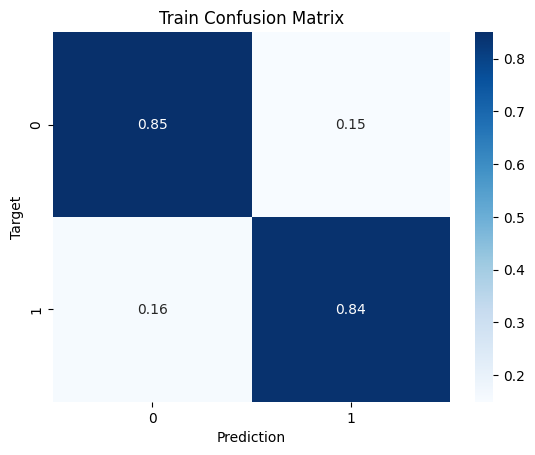

Area under ROC score on Validation dataset: 0.7571


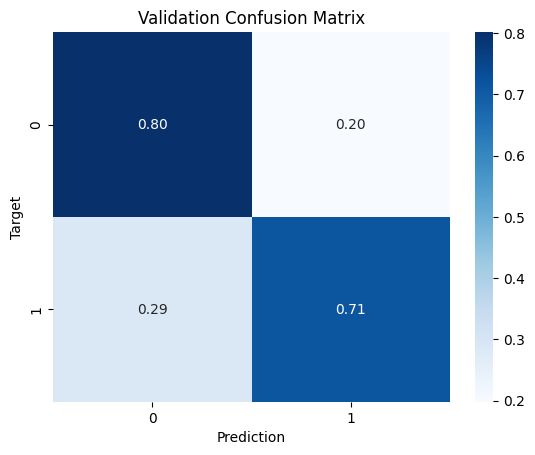


New model with polynomial features saved as 'bank-customer-churn-model-poly.joblib'


In [16]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Завантаження даних
raw_df = pd.read_csv('bank-customer-churn-modeling/Churn_Modelling.csv', index_col=0)
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42, stratify=raw_df['Exited'])

input_cols = list(train_df.columns)[1:-1]
target_col = 'Exited'
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

# Виявляємо числові і категоріальні колонки
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформери для числових і категоріальних колонок з PolynomialFeatures
numeric_transformer_poly4 = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('poly', PolynomialFeatures(degree=4, include_bias=False)), # Додаємо PolynomialFeatures
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Комбінуємо трансформери для різних типів колонок в новий препроцесор
preprocessor_poly4 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly4, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створюємо новий пайплайн з оновленим препроцесором
model_pipeline_poly4 = Pipeline(steps=[
    ('preprocessor', preprocessor_poly4),
    ('classifier', LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced'))
])

# Тренуємо новий пайплайн
print("Training new pipeline with polynomial features...")
model_pipeline_poly4.fit(train_inputs,train_targets)
print("Training complete.")

def predict_and_plot(model_pipeline_poly4, inputs, targets, name=''):
    preds = model_pipeline_poly4.predict(inputs)
    roc_auc = roc_auc_score(targets, preds)
    print(f"Area under ROC score on {name} dataset: {roc_auc:.4f}") # Збільшено точність відображення
    confusion_matrix_ = confusion_matrix(targets, preds, normalize='true')
    plt.figure()
    sns.heatmap(confusion_matrix_, annot=True, cmap='Blues', fmt=".2f") # Додано fmt для кращого форматування
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    return preds

# Оцінюємо нову модель на тренувальних і валідаційних даних
print("\n--- Metrics for Model with Polynomial Features ---")
train_preds_poly = predict_and_plot(model_pipeline_poly4, train_inputs, train_targets, 'Train')
val_preds_poly = predict_and_plot(model_pipeline_poly4,val_inputs, val_targets, 'Validation')

# Зберігаємо нову модель
joblib.dump(model_pipeline_poly4, 'bank-customer-churn-model-poly.joblib')
print("\nNew model with polynomial features saved as 'bank-customer-churn-model-poly.joblib'")

In [17]:
test_raw_df

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,1
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,24995,15642997.0,Chukwumaobim,639.0,Spain,Male,38.0,10.0,0.00,2.0,1.0,1.0,49637.65,0
9996,24996,15739271.0,Clements,678.0,Spain,Male,39.0,9.0,0.00,2.0,1.0,1.0,142513.50,0
9997,24997,15756743.0,Chidiebere,774.0,France,Male,30.0,9.0,0.00,2.0,1.0,0.0,4861.72,0
9998,24998,15680167.0,Yermakova,595.0,France,Male,38.0,6.0,144875.79,1.0,1.0,0.0,126469.09,0


In [18]:
test_input_df = test_raw_df.copy()

In [19]:
test_preds_poly4 = model_pipeline_poly4.predict(test_input_df)
test_preds_poly4

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
test_raw_df['Exited'] = test_preds_poly4

In [21]:
test_raw_df.head(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,1
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0
5,15005,15759066.0,Genovesi,611.0,France,Male,36.0,7.0,61811.23,1.0,1.0,0.0,145796.49,0
6,15006,15754926.0,Haddon,684.0,France,Female,36.0,0.0,0.00,2.0,1.0,0.0,161671.15,0
7,15007,15664802.0,Chiang,588.0,France,Male,39.0,4.0,0.00,2.0,0.0,0.0,57862.88,0
8,15008,15757537.0,Iweobiegbulam,612.0,Germany,Male,27.0,3.0,155413.06,2.0,1.0,0.0,140166.95,0
9,15009,15674928.0,Hoolan,736.0,France,Female,32.0,8.0,0.00,2.0,1.0,0.0,75969.19,0


In [22]:
submission_file_path = data_dir + '/sample_submission.csv'
submission = pd.read_csv(submission_file_path)
submission['Exited']=test_preds_poly4
submission.head()

,id,Exited
0,15000,0
1,15001,0
2,15002,0
3,15003,1
4,15004,0


In [23]:
output_filename = 'submission_log_reg_4.csv'
submission.to_csv(output_filename, index=False)

**Завдання 4. Перенавчання і регуляризація**.

  Скачайте набір даних `regression_data.csv`. Звичайте набір даних з `regression_data.csv`, розбийте на train і test (в тест 20%) і натренуйте модель лінійної регресії з масштабуванням числових ознак і поліноміальними ознаками до степені **5 включно**.

  Виміряйте якість прогностичної моделі і зробіть висновок, чи модель хороша, чи вона добре генералізує?




---
Виконання завдання:


In [26]:
import pandas as pd

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
!ls drive/MyDrive/ML/2_2/

regression_data.csv


Training regression pipeline with polynomial features (degree 5)...
Training complete.

--- Metrics for Linear Regression Model with Polynomial Features (degree 5) ---
Mean Squared Error on Train dataset: 0.0000
Root Mean Squared Error on Train dataset: 0.0000
R-squared score on Train dataset: 1.0000


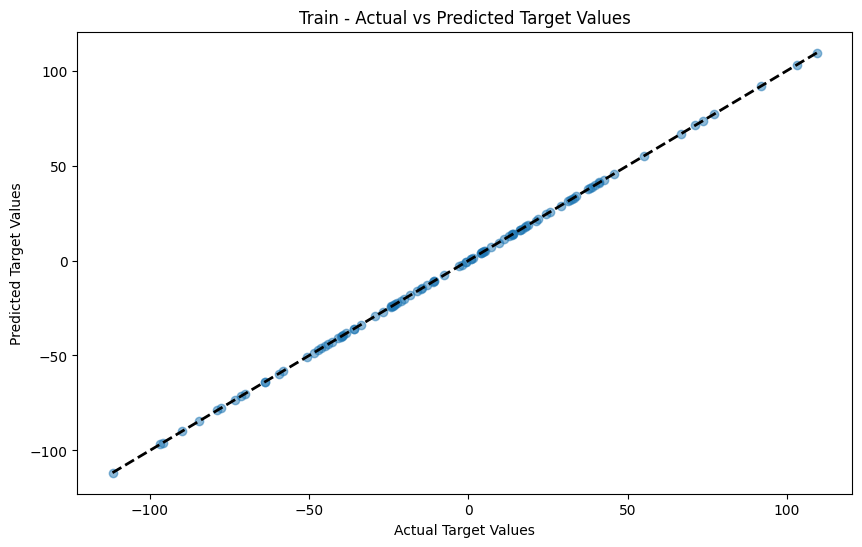

Mean Squared Error on Test Data dataset: 8328.0366
Root Mean Squared Error on Test Data dataset: 91.2581
R-squared score on Test Data dataset: -2.5696


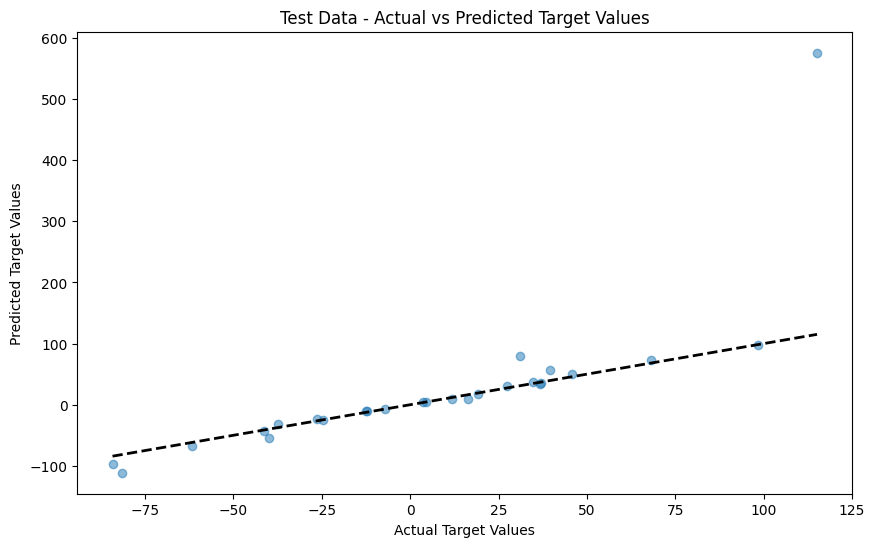

In [38]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression # Changed to LinearRegression
from sklearn.metrics import mean_squared_error, r2_score # Changed metrics for regression
import seaborn as sns
import matplotlib.pyplot as plt
import joblib


raw_df = pd.read_csv('drive/MyDrive/ML/2_2/regression_data.csv',index_col=0)

# Цільова колонка - 'target'
target_col = 'target'
input_cols = raw_df.columns.tolist()
input_cols.remove(target_col) # видаляємо цільову колонку з набору

# Розбиваємо дані на train на test
train_df, test_df = train_test_split(raw_df, test_size=0.2, random_state=42)

# Створюємо набори: train, test
train_inputs, train_targets = train_df[input_cols], train_df[target_col]
test_inputs, test_targets = test_df[input_cols], test_df[target_col]

# Визначаємо категріальні та числові змінні
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

# Створюємо трансформер для числових колонок з PolynomialFeatures (degree 5)
numeric_transformer = Pipeline(steps=[
    # ('imputer', SimpleImputer(strategy = 'mean')),
    ('poly', PolynomialFeatures(degree=5, include_bias=False)),
    ('scaler', MinMaxScaler())
])

# Категріальний трансформер. У цих даних нема категріальних колонок, але він потрібен для налаштування пайплайну для загалом, з урахуванням тих випадків, коли такі дані є.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Поєднання трансформарів у препроцессов
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Створення пайплайну з препроцессором та лінійною регресійною моделлю
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Тренування пайплайну
print("Training regression pipeline with polynomial features (degree 5)...")
model_pipeline.fit(train_inputs,train_targets)
print("Training complete.")

def evaluate_and_plot_regression(model_pipeline, inputs, targets, name=''):
    preds = model_pipeline.predict(inputs)
    mse = mean_squared_error(targets, preds)
    rmse = np.sqrt(mse) # Calculate RMSE
    r2 = r2_score(targets, preds) # Calculate R-squared
    print(f"Mean Squared Error on {name} dataset: {mse:.4f}")
    print(f"Root Mean Squared Error on {name} dataset: {rmse:.4f}")
    print(f"R-squared score on {name} dataset: {r2:.4f}")

    # Зображення графіків прогнозних значень і наявних
    plt.figure(figsize=(10, 6))
    plt.scatter(targets, preds, alpha=0.5)
    plt.xlabel("Actual Target Values")
    plt.ylabel("Predicted Target Values")
    plt.title(f"{name} - Actual vs Predicted Target Values")
    plt.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k--', lw=2) # Plotting a diagonal line for reference
    plt.show()

    return preds

# Evaluating the model on train and validation data
print("\n--- Metrics for Linear Regression Model with Polynomial Features (degree 5) ---")
train_preds = evaluate_and_plot_regression(model_pipeline, train_inputs, train_targets, 'Train')
test_preds = evaluate_and_plot_regression(model_pipeline, test_inputs, test_targets, 'Test Data')

# Saving the model (optional for this task, but good practice)
# joblib.dump(model_pipeline, 'regression-model-poly5.joblib')
# print("\nRegression model with polynomial features (degree 5) saved as 'regression-model-poly5.joblib'")

Висновки: Ось ключові метрики, які ми отримали для тренувального та тестового наборів даних:

Метрики для тренувального набору даних:

Mean Squared Error (MSE): 0.0000

Root Mean Squared Error (RMSE): 0.0000

R-squared score: 1.0000

Ці показники на тренувальному наборі є майже ідеальними, що модель дуже добре підігнана під тренувальні дані. Вона практично без помилок передбачає цільові значення на даних, на яких навчалася.

Метрики для тестового набору даних:

Mean Squared Error (MSE): 8328.0366

Root Mean Squared Error (RMSE): 91.2581

R-squared score: -2.5696

На тестовому наборі даних ситуація кардинально інша:

Високі значення MSE та RMSE: Це свідчить про значні помилки в передбаченнях моделі на нових, небачених даних.
Тобто на тренувальних даних модель виглядає ідеальною, але на тестових даних її якість дуже низька. Величезна різниця між метриками на тренувальному та тестовому наборах є яскравим прикладом перенавчання (overfitting).



---



**Завдання 5**. Натренуйте моделі Lasso(), Ridge(), ElasaticNet() на цих даних (з поліном ознаками до степені 20 включно), порівняйте якість з тою, яка була отримана з лінійною регресією. Яка модель найкраще генералізує і чому на ваш погляд (можливо треба буде для відповіді зробити додатковий аналіз ознак)?

In [39]:
from sklearn.linear_model import Ridge,Lasso, ElasticNet
models=[
    Lasso(),
    Ridge(),
    ElasticNet(),
    ElasticNet(alpha=0.5)
]

In [40]:
def evaluate_model(model,train_inputs, train_targets,test_inputs, test_targets):
  train_predicted = model.predict(train_inputs)
  test_predicted = model.predict(test_inputs)

  train_metrics = mean_squared_error(train_targets, train_predicted )
  test_metrics = mean_squared_error(test_targets, test_predicted)
  return dict(train_metrics=train_metrics, test_metrics=test_metrics)

In [41]:
poly_features_10 = PolynomialFeatures(degree=10)
train_inputs_poly = poly_features_10.fit_transform(train_inputs)
test_inputs_poly = poly_features_10.transform(test_inputs)

In [42]:
import warnings
warnings.filterwarnings('ignore')
for model in models:
  model.fit(train_inputs_poly, train_targets)
  metrics = evaluate_model(model,train_inputs_poly, train_targets, test_inputs_poly, test_targets)
  print(f'{str(model)}: {metrics}\n')

Lasso(): {'train_metrics': 4.45030038933311, 'test_metrics': 13.800287611685171}

Ridge(): {'train_metrics': 1.9326818716748393, 'test_metrics': 654785.1337885761}

ElasticNet(): {'train_metrics': 125.72128015521166, 'test_metrics': 61326.732286651546}

ElasticNet(alpha=0.5): {'train_metrics': 75.30067957820998, 'test_metrics': 32007.569397281375}



### **Порівняння з попередньою моделлю:**

Попередня модель (LinearRegression, степінь 5) мала такі результати:

Train MSE: 0.0000

Test MSE: 8328.0366

Тепер порівняємо ці результати з моделями регуляризації (при використанні поліноміальних ознак степеня 10):

**Lasso():**

Train MSE: 4.45

Test MSE: 13.80

Висновок: Lasso показує набагато кращу генералізацію порівняно з LinearRegression степеня 5. Різниця між тренувальним та тестовим MSE значно менша. Це вказує на те, що Lasso успішно зменшив перенавчання, можливо, шляхом обнулення деяких неважливих ознак, які виникли при генерації поліноміальних ознак.

**Ridge():**

Train MSE: 1.93

Test MSE: 654785.13

Висновок: Ridge також показує низький MSE на тренувальному наборі, але дуже високий MSE на тестовому наборі. Це свідчить про сильне перенавчання, навіть гірше, ніж у LinearRegression

ElasticNet() та ElasticNet(alpha=0.5):

ElasticNet():
Train MSE: 125.72,
Test MSE: 61326.73

ElasticNet(alpha=0.5):
Train MSE: 75.30,
Test MSE: 32007.57

Висновок: Ці моделі ElasticNet показують кращі результати на тестовому наборі порівняно з Ridge, але значно гірші, ніж Lasso. Значення MSE на тестовому наборі все ще високі, що вказує на значне перенавчання.

AI підказав, що моделі Lasso(), Ridge(), ElasaticNet() чутливі до масштабування. Тому застосую його перед навчанням моделей

In [43]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Визначаємо степінь поліноміальних ознак
poly_degree = 10

# Створюємо трансформер для числових колонок з PolynomialFeatures та MinMaxScaler
numeric_transformer_poly_scaled = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=poly_degree, include_bias=False)),
    ('scaler', MinMaxScaler())
])

# Оскільки в цьому наборі даних немає категоріальних колонок,
# ми створимо ColumnTransformer тільки для числових
preprocessor_poly_scaled = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_poly_scaled, numeric_cols)
    ],
    remainder='passthrough' # Залишити інші колонки без змін, хоча тут їх немає
)

# Визначаємо моделі регуляризації
models_to_evaluate = {
    'Lasso': Lasso(),
    'Ridge': Ridge(),
    'ElasticNet': ElasticNet(),
    'ElasticNet(alpha=0.5)': ElasticNet(alpha=0.5)
}

# Створюємо та тренуємо пайплайни для кожної моделі
results = {}
for name, model in models_to_evaluate.items():
    # Створюємо пайплайн: препроцесор + модель
    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_poly_scaled),
        ('regressor', model)
    ])

    print(f"Training {name} model with polynomial features (degree {poly_degree}) and scaling...")
    # Тренуємо пайплайн
    full_pipeline.fit(train_inputs, train_targets)
    print(f"Training complete for {name}.")

    # Оцінюємо модель
    train_preds = full_pipeline.predict(train_inputs)
    test_preds = full_pipeline.predict(test_inputs)

    train_mse = mean_squared_error(train_targets, train_preds)
    test_mse = mean_squared_error(test_targets, test_preds)

    results[name] = {'train_mse': train_mse, 'test_mse': test_mse}
    print(f"{name}: Train MSE = {train_mse:.4f}, Test MSE = {test_mse:.4f}\n")

print("\n--- Comparison of Models with Polynomial Features (degree 10) and Scaling ---")
for name, metrics in results.items():
    print(f"{name}: Train MSE = {metrics['train_mse']:.4f}, Test MSE = {metrics['test_mse']:.4f}")

Training Lasso model with polynomial features (degree 10) and scaling...
Training complete for Lasso.
Lasso: Train MSE = 25.9914, Test MSE = 32.1708

Training Ridge model with polynomial features (degree 10) and scaling...
Training complete for Ridge.
Ridge: Train MSE = 77.8211, Test MSE = 1297.1061

Training ElasticNet model with polynomial features (degree 10) and scaling...
Training complete for ElasticNet.
ElasticNet: Train MSE = 1359.7326, Test MSE = 1553.6961

Training ElasticNet(alpha=0.5) model with polynomial features (degree 10) and scaling...
Training complete for ElasticNet(alpha=0.5).
ElasticNet(alpha=0.5): Train MSE = 1015.6741, Test MSE = 1219.5022


--- Comparison of Models with Polynomial Features (degree 10) and Scaling ---
Lasso: Train MSE = 25.9914, Test MSE = 32.1708
Ridge: Train MSE = 77.8211, Test MSE = 1297.1061
ElasticNet: Train MSE = 1359.7326, Test MSE = 1553.6961
ElasticNet(alpha=0.5): Train MSE = 1015.6741, Test MSE = 1219.5022


**Висновки:**
Lasso (Train MSE = 25.9914, Test MSE = 32.1708):

Має найнижчий MSE як на тренувальному, так і на тестовому наборах серед усіх моделей регуляризації.
Різниця між тренувальним та тестовим MSE є невеликою (32.1708 - 25.9914 = 6.1794). Це свідчить про те, що модель добре генералізує і має мінімальне перенавчання порівняно з іншими.

Ridge (Train MSE = 77.8211, Test MSE = 1297.1061):

Хоча MSE на тренувальному наборі є відносно низьким, MSE на тестовому наборі значно вищий.
Велика різниця між тренувальним та тестовим MSE (1297.1061 - 77.8211 = 1219.285) вказує на сильне перенавчання. Модель добре підігналась під тренувальні дані, але погано справляється з новими.

ElasticNet (Train MSE = 1359.7326, Test MSE = 1553.6961):

Цей варіант ElasticNet має найвищі значення MSE на обох наборах даних.
Різниця між тренувальним та тестовим MSE є меншою, ніж у Ridge (1553.6961 - 1359.7326 = 194.3635), але загальна якість (за показником MSE) є гіршою.

ElasticNet(alpha=0.5) (Train MSE = 1015.6741, Test MSE = 1219.5022):

Цей варіант ElasticNet показує кращі результати порівняно з ElasticNet за замовчуванням (менші MSE).
Різниця між тренувальним та тестовим MSE становить 203.8281, що також свідчить про певне перенавчання, але менше, ніж у Ridge.

**Загальний висновок:**
Отже, модель **Lasso** показала мебе найкраще як з маштабуванням даний так і без нього